This notebook reads a previously trained Autoencoder. It is assumed that the model was trained with the `train.py` script which reads in the `train_config.yaml` configuration file.

---

### 1. Evaluate trained Autoencoder

In [1]:
import sys
import torch
import torch.nn as nn
from torchvision.transforms import Lambda
import numpy as np
import matplotlib.pyplot as plt
import yaml 
import importlib

sys.path.append("../../")
from ae_class import AE

# Read training config.
#------------------------
config_path = "train_config.yaml"
with open(config_path,"r") as  f:
    ae_config = yaml.safe_load(f)
    
# Init. turbAE object
#---------------------
ae = AE(ae_config)
x_min,x_max = ae.get_minmax_values()

# Import NN architecture
#---------------------------
sys.path.append(ae.model_path)
nn_module = importlib.import_module(ae.model_name)

# Import testing data
#---------------------
transform_minmax = Lambda(lambda x:(x - x_min)/(x_max - x_min))
transform_minmax_undo = Lambda(lambda x: x*(x_max-x_min)+x_min)  # reverse min-max normalization
data_test = torch.from_numpy(np.load(ae.datapath)[(ae.trainingLength+ae.validationLength):])
data_test = transform_minmax(data_test)

1.05e-03


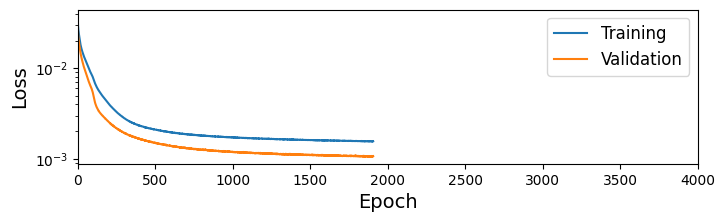

In [2]:
# Read Autoencoder training information
#--------------------------------------
loss_dict = ae.read_history()
model = torch.load(ae.cp_path) 

# Plot Loss
#-------------
fig,axs = plt.subplots(figsize=(8,2))
axs.semilogy(range(1,len(loss_dict["train_loss"])+1),loss_dict["train_loss"],label="Training")
axs.semilogy(range(1,len(loss_dict["val_loss"])+1),loss_dict["val_loss"],label="Validation")

axs.set_xlabel("Epoch",fontsize=14)
axs.set_ylabel("Loss",fontsize=14)
axs.set_xlim([0,ae.num_epochs])
axs.legend(fontsize=12)
print("{0:.2e}".format(loss_dict["val_loss"].min()))

In [3]:
# Run AE
#---------
if hasattr(model,"module"):
    model = model.module
model.eval()
decoded, encoded = model(data_test)
encoded = encoded.detach()
decoded = decoded.detach()
decoded = transform_minmax_undo(decoded)

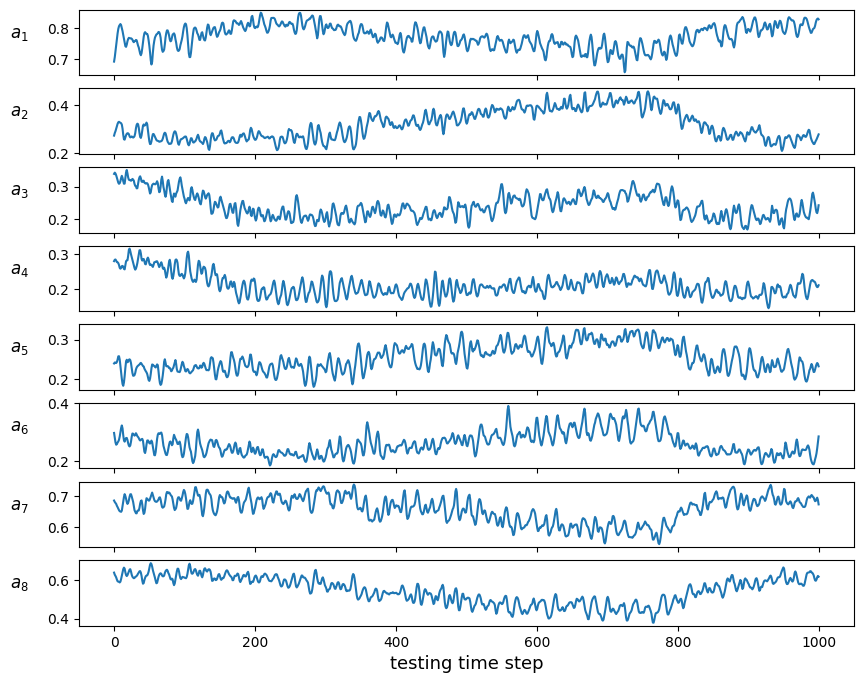

In [4]:
# Plot some of the Encoder output dimensions over time
#---------------------------------------------------------
fig,axs = plt.subplots(figsize=(10,ae.encoding_dim//4*1),nrows=ae.encoding_dim//4,sharex=True)

for ii,imode in enumerate(range(ae.encoding_dim//4)):
    axs[ii].plot(encoded[:,imode])
    axs[ii].set_ylabel(r"$a_{"+f"{imode+1}"+r"}$",rotation=0,labelpad=20,fontsize=12)
    
axs[-1].set_xlabel("testing time step",fontsize=13)
for iax in axs:
    pass
    #iax.set_ylim([0,1])

Text(0, 0.5, 'AE')

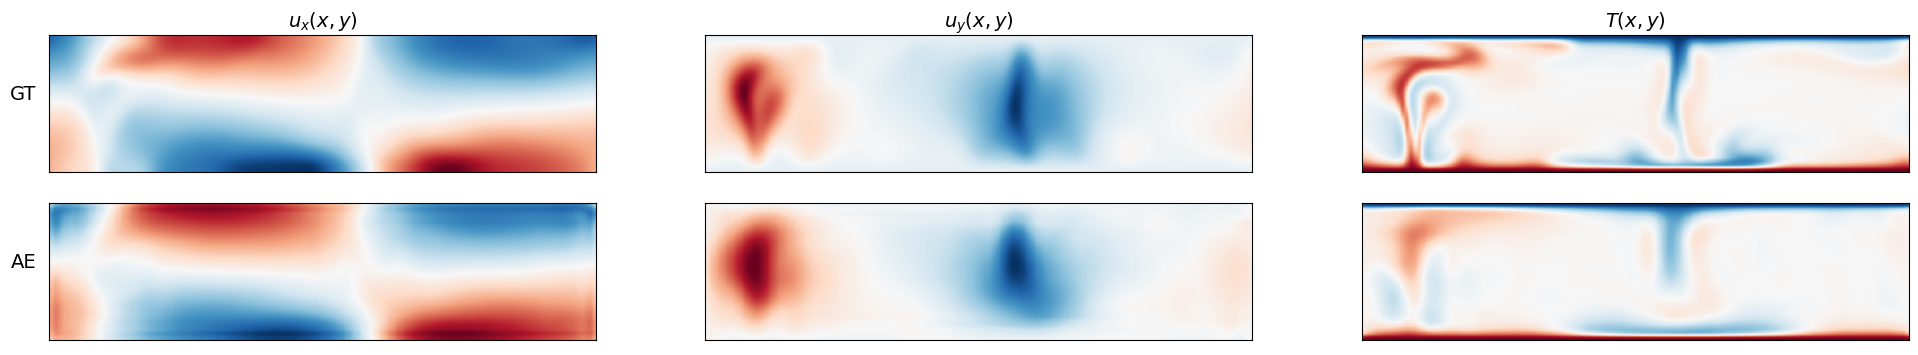

In [5]:
import matplotlib.pyplot as plt

it = 0  # which snapshot in the testing phase to show

fig,axs = plt.subplots(figsize=(8*ae.nfields,2*2),ncols=ae.nfields,nrows=2)
for ii,ifield in enumerate(range(ae.nfields)):
    axs[0,ii].imshow(data_test[it,ifield].flip(0),cmap="RdBu_r",interpolation="gaussian")
    axs[1,ii].imshow(decoded[it,ifield].flip(0),  cmap="RdBu_r",interpolation="gaussian")
    
for iax in axs.flatten():
    iax.set_xticks([])
    iax.set_yticks([])
axs[0,0].set_title(r"$u_x(x,y)$",fontsize=14)
axs[0,1].set_title(r"$u_y(x,y)$",fontsize=14)
axs[0,2].set_title(r"$T(x,y)$",fontsize=14)

axs[0,0].set_ylabel("GT",rotation=0,fontsize=14,labelpad=15)
axs[1,0].set_ylabel("AE",rotation=0,fontsize=14,labelpad=15)

---

### 2. Save encoded data (training + validation + testing)

In [6]:
data_all  = torch.from_numpy(np.load(ae.datapath))
data_all = transform_minmax(data_all)

model.eval()
encoded_all = model.encoder(data_all)
encoded_all = encoded_all.detach().numpy()

#Save encoding space
#----------------------
#np.save("RBC_A4Ra1e6Pr10_fs_encoded_all.npy",encoded_all)

# Load saved encoding space
#---------------------------
#encoded_all = np.load("RBC_A4Ra1e6Pr10_fs_encoded_all.npy")

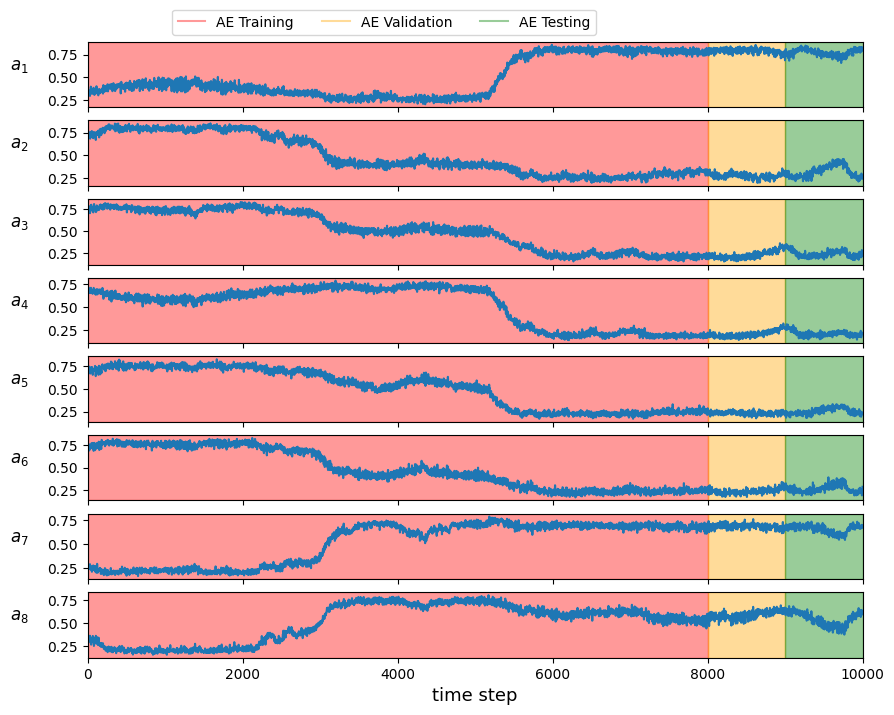

In [7]:
from matplotlib.lines import Line2D

# Plot some of the Encoder output dimensions over time
#---------------------------------------------------------
alpha = 0.4 # opacity
fig,axs = plt.subplots(figsize=(10,ae.encoding_dim//4*1),nrows=ae.encoding_dim//4,sharex=True)

for ii,imode in enumerate(range(ae.encoding_dim//4)):
    axs[ii].plot(encoded_all[:,imode])
    axs[ii].set_ylabel(r"$a_{"+f"{imode+1}"+r"}$",rotation=0,labelpad=20,fontsize=12)
    axs[ii].axvspan(xmin=0,xmax=ae.trainingLength,color="red",alpha=alpha)
    axs[ii].axvspan(xmin=ae.trainingLength,xmax=ae.trainingLength+ae.validationLength,color="orange",alpha=alpha)
    axs[ii].axvspan(xmin=ae.trainingLength+ae.validationLength,xmax=ae.trainingLength+ae.validationLength+ae.testingLength,color="green",alpha=alpha)
    
axs[-1].set_xlabel("time step",fontsize=13)
for iax in axs:
    iax.set_xlim([0,ae.trainingLength+ae.testingLength+ae.validationLength])
    #iax.set_ylim([0,1])
    
axs[0].legend([Line2D([0,],[0,],color="red",alpha=alpha),
               Line2D([0,],[0,],color="orange",alpha=alpha),
               Line2D([0,],[0,],color="green",alpha=alpha)],
              ["AE Training","AE Validation","AE Testing"]
              ,loc="lower left",bbox_to_anchor=(0.1,1),ncol=3)
